In [1]:
from interpret.glassbox import ExplainableBoostingRegressor as ebr
from interpret import show
import numpy as np
import pandas as pd


from ebm_utils.analysis.purify_utils import purify, purify_and_update
# Purification requires installing https://github.com/blengerich/gam_purification by:
# pip install git+https://github.com/blengerich/gam_purification.git
# See paper http://proceedings.mlr.press/v108/lengerich20a.html for more details
from ebm_utils.analysis.plot_utils import plot_all_features, plot_importances

In [2]:
X = pd.DataFrame(np.random.uniform(0, 1, size=(1000, 2)), columns=['Feature 1', 'Feature 2'])
Y = X.values[:, 0]*X.values[:, 1]

In [3]:
ebm = ebr(interactions=2)
ebm.fit(X, Y)
ebm_global = ebm.explain_global()

# Extract purified numpy versions of the effects learned by the EBMs.
results_empirical = purify(ebm_global, use_density=True, dataset_name="toy",
                 move_name="empirical", X_train=X, X_means=np.mean(X, axis=0), X_stds=np.std(X, axis=0),
                 laplace=0, should_transpose=False)
results_smoothed = purify(ebm_global, use_density=True, dataset_name="toy",
                 move_name="smoothed", X_train=X, X_means=np.mean(X, axis=0), X_stds=np.std(X, axis=0),
                 laplace=10, should_transpose=False)
# These functions return the original mains and pairs, along with purified ('moved') versions of each.
print(results_smoothed.keys())

dict_keys(['mains', 'mains_moved', 'pairs', 'pairs_moved', 'intercept'])


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_interaction(results):
    fig = plt.figure()
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(1, 2),
                     share_all=True,
                     cbar_location='right',
                     cbar_mode='single',
                     cbar_size='7%',
                     cbar_pad=0.15,
                     axes_pad=0.1)

    extent = (ebm_global.data(0)['names'][0],
              ebm_global.data(0)['names'][-1],
              ebm_global.data(1)['names'][0],
              ebm_global.data(1)['names'][-1])

    aspect = float(extent[3] - extent[2]) / float(extent[1] - extent[0])
    aspect = 1/aspect

    im = grid[0].imshow(results['pairs'][(0, 1)], aspect=aspect, origin='lower',
                        interpolation='none', extent=extent)
    im = grid[1].imshow(results['pairs_moved'][(0, 1)], aspect=aspect, origin='lower',
                        interpolation='none', extent=extent)

    # Colorbar
    ax = grid[-1]
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)

    grid[0].set_ylabel("X_2", fontsize=22)
    grid[0].set_xlabel("X_1", fontsize=22)
    grid[1].set_xlabel("X_1", fontsize=22)
    grid[0].tick_params(axis='both', which='major', labelsize=16)
    grid[0].tick_params(axis='both', which='minor', labelsize=12)
    grid[1].tick_params(axis='both', which='major', labelsize=16)
    grid[1].tick_params(axis='both', which='minor', labelsize=12)
    ax.cax.tick_params(axis='both', which='major', labelsize=16)
    ax.cax.tick_params(axis='both', which='minor', labelsize=12)
    grid[0].set_title("Before Purification")
    grid[1].set_title("After Purification")
    plt.show()

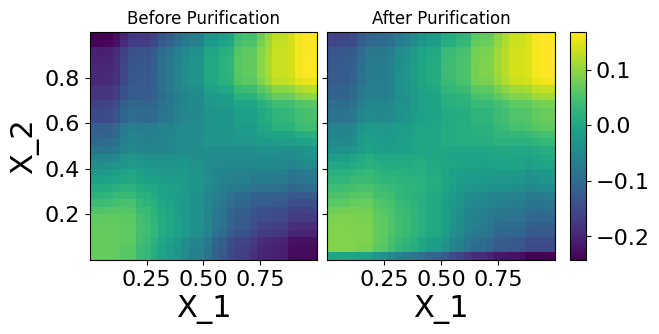

In [5]:
# Purify using the empirical density -- bumpy.
plot_interaction(results_empirical)

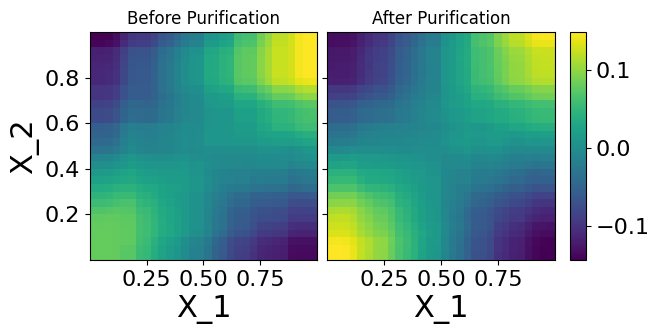

In [6]:
# Purify using a Laplacian-smoothed version of the empirical density.
plot_interaction(results_smoothed)

In [7]:
# Notice that these purified pairwise interaction effects look like "XOR",
# even though the original function was multiplication.

=========Before Purification=======


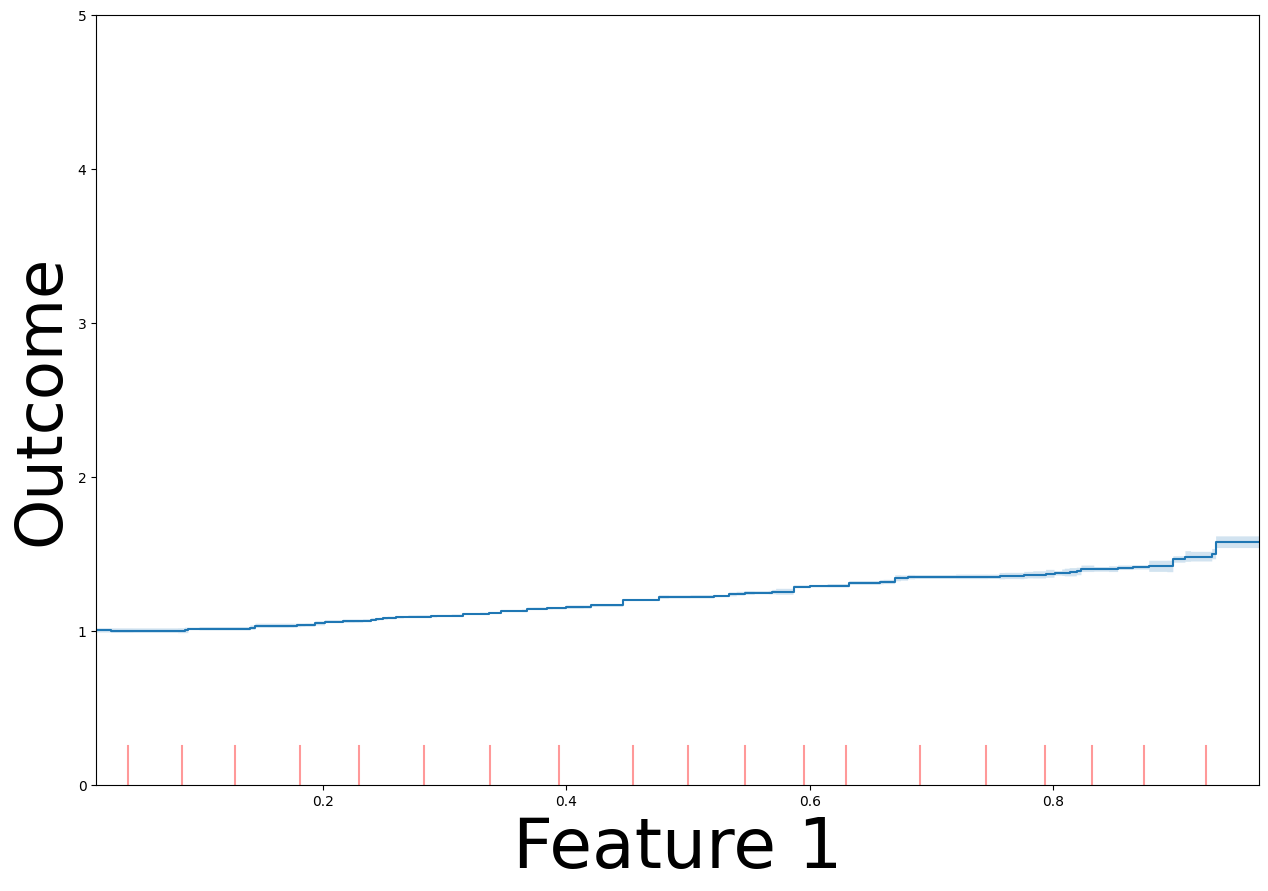

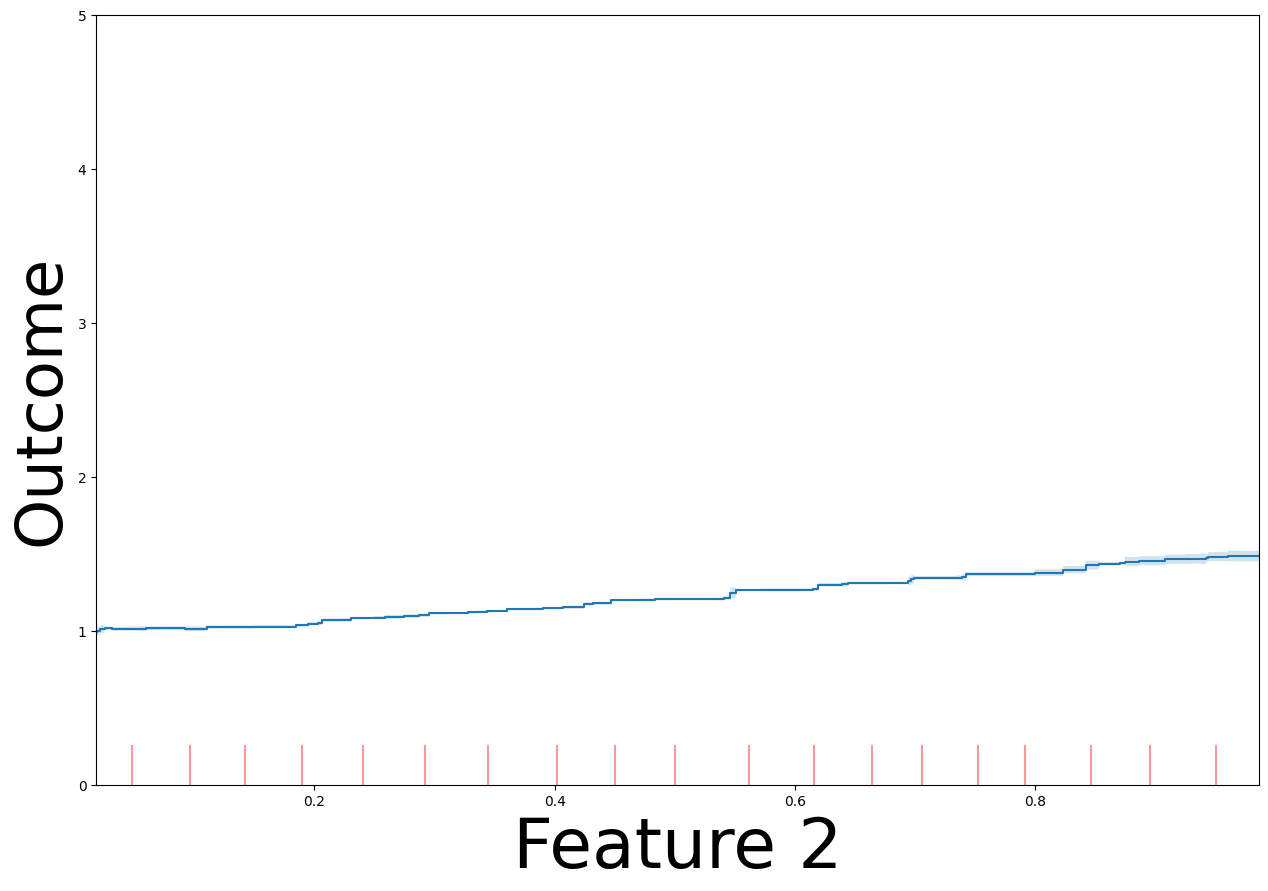

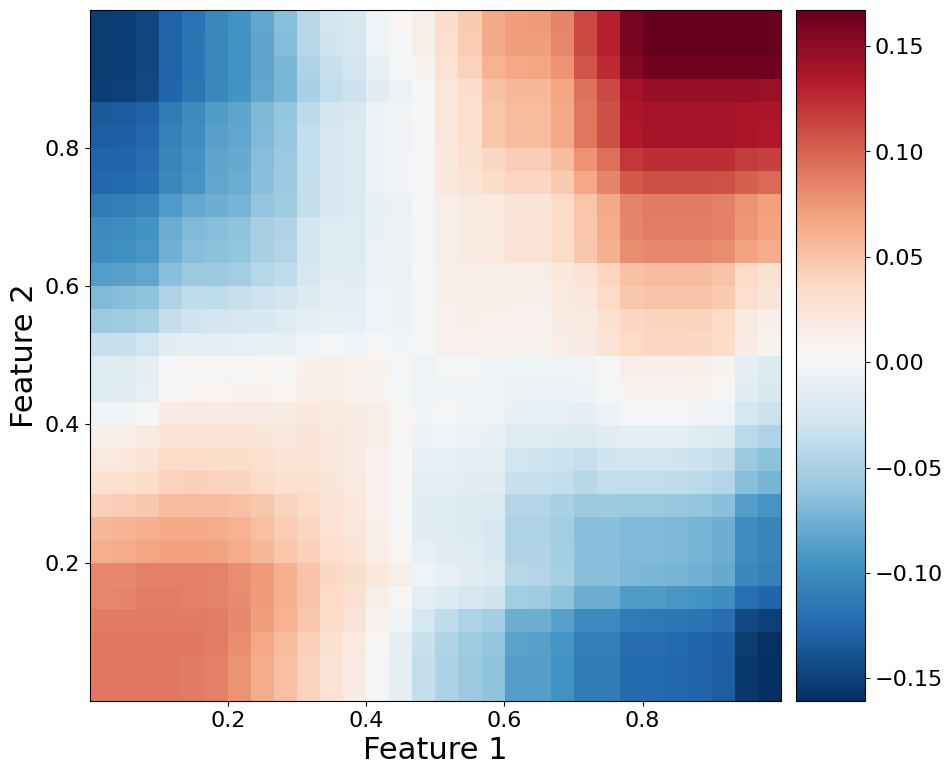

=======After Purification=========


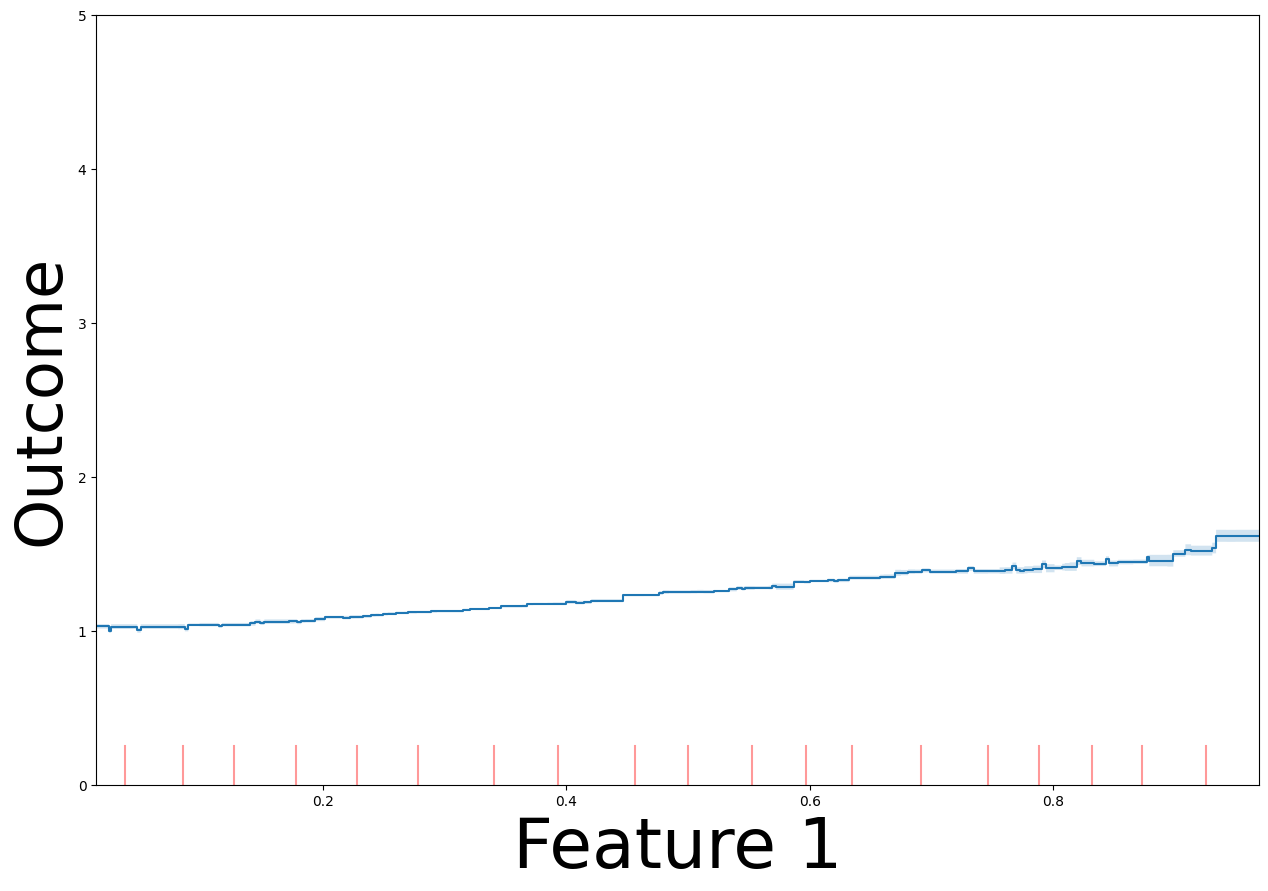

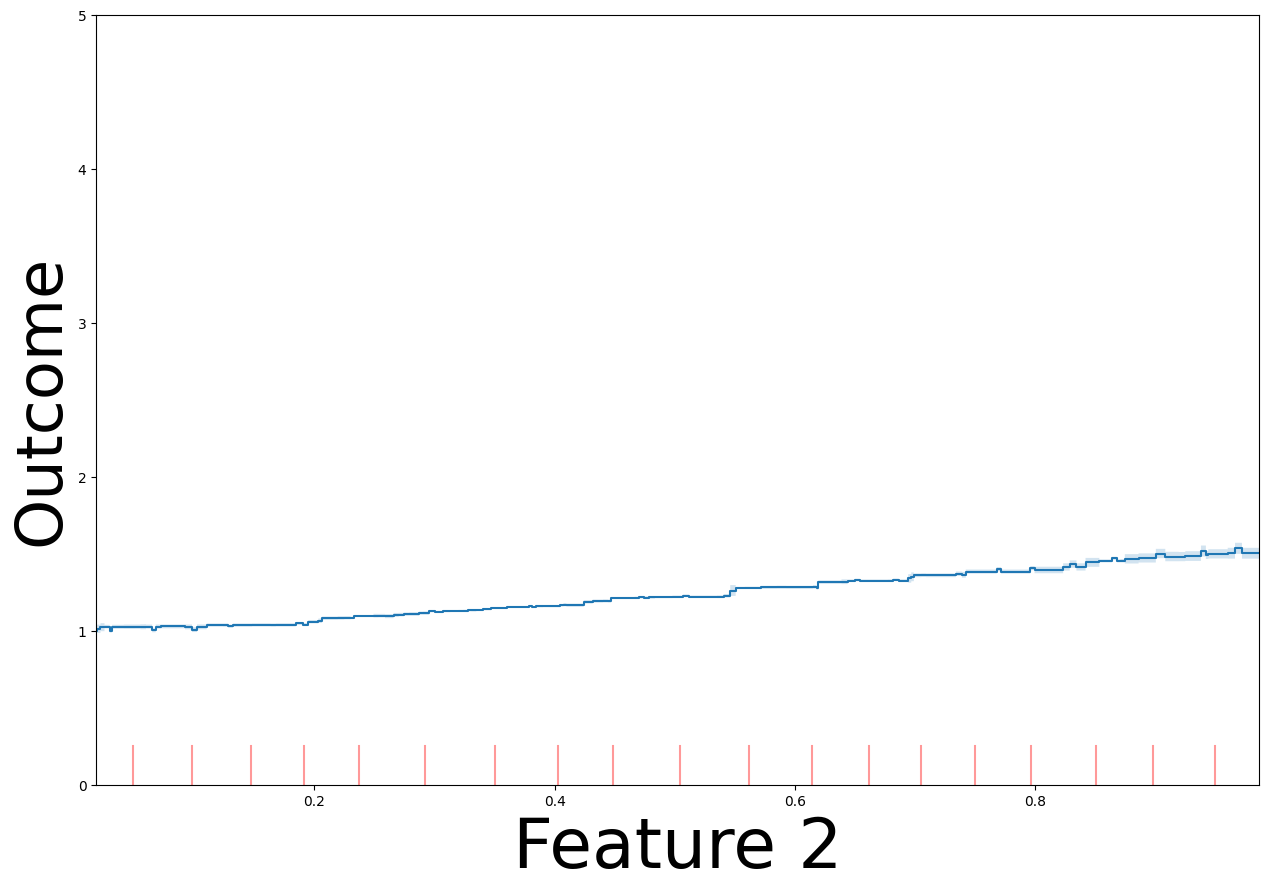

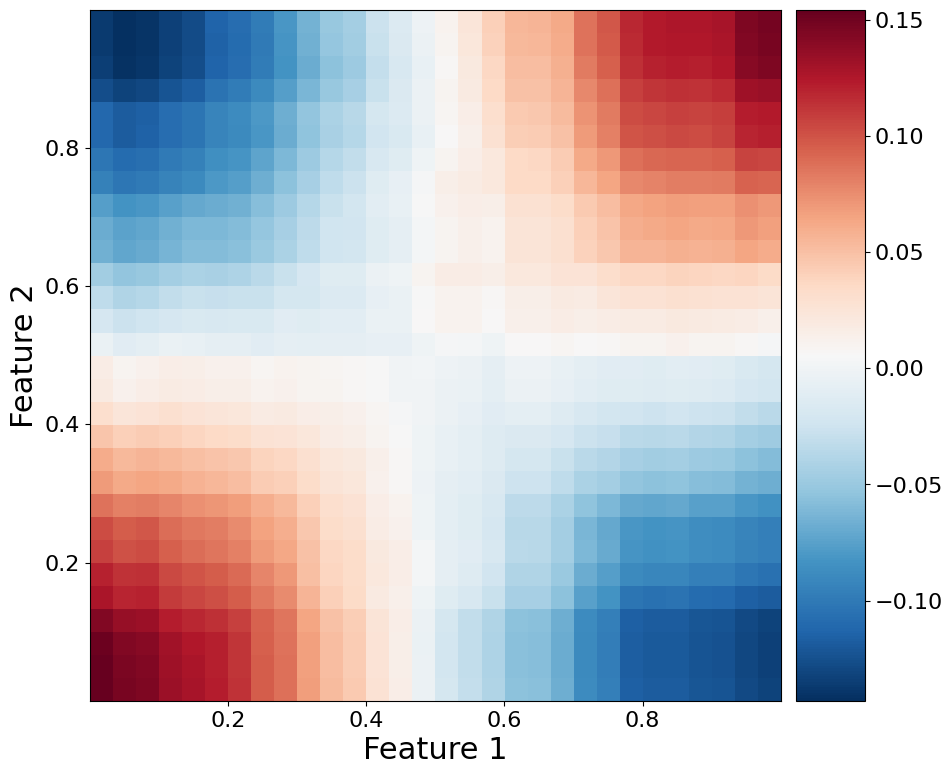

In [8]:
# The above functions don't update the EBM itself.
# If we want in-place changes to the EBM, we can use the helper function
# purify_and_update

print("=========Before Purification=======")
plot_all_features(
    ebm.explain_global(), X,
    bool_mpl_style=True, bool_figsize=(12, 12),
    ylabel='Outcome',
)

purify_and_update(ebm, use_density=True, dataset_name="toy", move_name="smoothed",
                  X_train=X, X_means=np.mean(X, axis=0), X_stds=np.std(X, axis=0),
                  laplace=10, should_transpose=False)

print("=======After Purification=========")
plot_all_features(
    ebm.explain_global(), X,
    bool_mpl_style=True, bool_figsize=(12, 12),
    ylabel='Outcome',
)